# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding

,Price in USDT,Weights in %
Total,1768.674679,1.000000e+00
BTCUSDT,739.321555,4.180088e-01
JASMYUSDT,257.521113,1.456012e-01
SOLUSDT,253.025419,1.430593e-01
OMUSDT,182.242655,1.030391e-01
ETHUSDT,179.065284,1.012426e-01
BBUSDT,103.116754,5.830171e-02
BNBUSDT,54.372713,3.074207e-02
TRXUSDT,0.009184,5.192571e-06
PEPEUSDT,0.000002,9.824305e-10


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.interpolate()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
historical_ptf=pd.DataFrame()

In [20]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

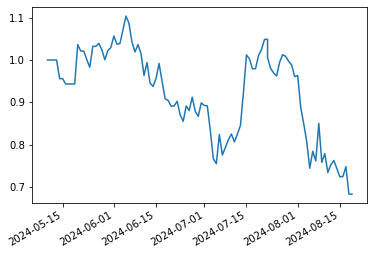

In [21]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [22]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [23]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [24]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT',
       'EGLDUSDT', 'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT',
       'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT',
       'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT',
       'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT',
       'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT',
       'WBTCUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT', 'ZECUSDT'],
      dtype='object')

In [25]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [26]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.450073
BTCUSDT,0.400000
BNBUSDT,0.066770
PEPEUSDT,0.055310
JASMYUSDT,0.027848


In [27]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [28]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.881774
OMUSDT,0.118226


## Real Portfolio vs Optimal

In [29]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,739.321555,4.180088e-01,0.000000,0.000000
JASMYUSDT,257.521113,1.456012e-01,0.000000,0.000000
SOLUSDT,253.025419,1.430593e-01,0.000000,0.000000
OMUSDT,182.242655,1.030391e-01,0.118226,-0.015187
ETHUSDT,179.065284,1.012426e-01,0.000000,0.000000
BBUSDT,103.116754,5.830171e-02,0.000000,0.000000
BNBUSDT,54.372713,3.074207e-02,0.000000,0.000000
TRXUSDT,0.009184,5.192571e-06,0.881774,-0.881769
PEPEUSDT,0.000002,9.824305e-10,0.000000,0.000000


In [30]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,739.321555,4.180088e-01,0.400000,0.018009
JASMYUSDT,257.521113,1.456012e-01,0.027848,0.117753
SOLUSDT,253.025419,1.430593e-01,0.000000,0.000000
OMUSDT,182.242655,1.030391e-01,0.450073,-0.347034
ETHUSDT,179.065284,1.012426e-01,0.000000,0.000000
BBUSDT,103.116754,5.830171e-02,0.000000,0.000000
BNBUSDT,54.372713,3.074207e-02,0.066770,-0.036028
TRXUSDT,0.009184,5.192571e-06,0.000000,0.000000
PEPEUSDT,0.000002,9.824305e-10,0.055310,-0.055310


## Risk Reward Analysis

In [31]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [32]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

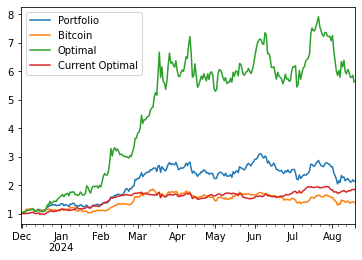

In [33]:
(1+portfolio_perf).cumprod().plot()

In [34]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

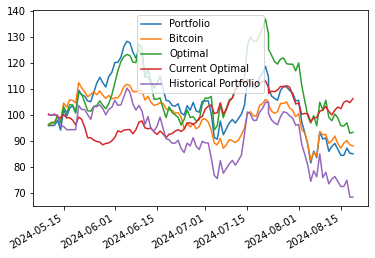

In [35]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [36]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.726401
dtype: float64

In [37]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.575487
dtype: float64

In [38]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.528710
Bitcoin            0.451215
Optimal            0.727747
Current Optimal    0.315153
dtype: float64

In [39]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.37199080768614357

In [40]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.010094,0.017199,0.020502,0.002177,0.018325
BTCUSDT,0.022188,0.069550,0.157356,0.061507,0.095849
JASMYUSDT,0.004609,0.007523,0.016218,0.001913,0.014305
OMUSDT,0.949512,0.886902,0.760278,0.664475,0.095803
PEPEUSDT,0.013598,0.018827,0.045646,0.010478,0.035168


In [41]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.342213,0.431875,0.284476,0.097988,0.186488
JASMYUSDT,0.143801,0.150946,0.245399,0.082225,0.163174
SOLUSDT,0.139685,0.140048,0.150951,0.030510,0.120441
OMUSDT,-0.049995,0.122898,0.097373,0.024218,0.073155
ETHUSDT,0.134297,0.094764,0.082871,0.010008,0.072863
BBUSDT,0.259119,0.029603,0.117880,0.027352,0.090528
BNBUSDT,0.030880,0.029866,0.021051,0.000632,0.020420


## Value At Risk

### Historical

In [42]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06315642005654605, -0.08534681438430448)

In [43]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05460752669164765, -0.07463858645821309)

In [44]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [45]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.017469
JASMYUSDT   -0.011600
SOLUSDT     -0.011637
OMUSDT      -0.004401
ETHUSDT     -0.004530
BBUSDT      -0.002478
BNBUSDT     -0.002084
TRXUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.054199
Name: 2024-07-07 00:00:00, dtype: float64

In [46]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.020977
JASMYUSDT   -0.016452
SOLUSDT     -0.011254
OMUSDT      -0.008519
ETHUSDT     -0.006048
BBUSDT      -0.006228
BNBUSDT     -0.001755
TRXUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.071232
dtype: float64

### Parametric

In [47]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07540630914069898, -0.09665003962856719)

In [48]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05962970005394338, -0.07642878877017771)

### Multivariate

In [49]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0677983298330498, -0.08697225058601565)

In [50]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05930386182112856, -0.07354133607070419)

In [51]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.017155
JASMYUSDT   -0.015745
SOLUSDT     -0.008511
OMUSDT      -0.005753
ETHUSDT     -0.004728
BBUSDT      -0.006824
BNBUSDT     -0.001274
Portfolio   -0.059989
dtype: float64

### Copulas

In [52]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06756033677943948, -0.0872582181517303)

In [53]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0598908696570005, -0.07528169645178616)

In [54]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.017544
JASMYUSDT   -0.014923
SOLUSDT     -0.008522
OMUSDT      -0.005470
ETHUSDT     -0.004944
BBUSDT      -0.007289
BNBUSDT     -0.001352
Portfolio   -0.060044
dtype: float64

In [55]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06689237899438581, -0.08689525841734894)

In [56]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.060927983638326556, -0.0768999915139636)

In [57]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.017496
JASMYUSDT   -0.015159
SOLUSDT     -0.008829
OMUSDT      -0.005801
ETHUSDT     -0.005101
BBUSDT      -0.007494
BNBUSDT     -0.001288
Portfolio   -0.061167
dtype: float64

In [58]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13384198787693413, -0.19386146080917438)

In [59]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06563409318046108, -0.08754459319639643)

In [60]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.026634
JASMYUSDT   -0.019818
SOLUSDT     -0.005454
OMUSDT      -0.004729
ETHUSDT     -0.000987
BBUSDT      -0.008167
BNBUSDT     -0.000265
Portfolio   -0.066055
dtype: float64

### Monte Carlo

In [61]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [62]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07617773637930109, -0.09554816065488043)

In [63]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06103893950008556, -0.07618441813903112)

In [64]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.017550
JASMYUSDT   -0.015184
SOLUSDT     -0.008901
OMUSDT      -0.005681
ETHUSDT     -0.004981
BBUSDT      -0.007252
BNBUSDT     -0.001226
Portfolio   -0.060774
dtype: float64

### VaR Violation

In [65]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.057883,-0.103636,-0.089149,-0.024242
2024-01-15,-0.057883,-0.103632,-0.091415,0.017718
2024-01-16,-0.057883,-0.104200,-0.084056,0.056785
2024-01-17,-0.057883,-0.106483,-0.088628,-0.034420
2024-01-18,-0.057883,-0.108483,-0.089336,-0.033196
...,...,...,...,...
2024-08-15,-0.068515,-0.081055,-0.088413,-0.029830
2024-08-16,-0.068515,-0.081069,-0.090069,-0.001632
2024-08-17,-0.068515,-0.081490,-0.088184,0.012854
2024-08-18,-0.068515,-0.081862,-0.092472,-0.041974


In [66]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036934,-0.090066,-0.079677,-0.017937
2024-05-29,-0.027005,-0.086203,-0.072388,-0.015067
2024-05-30,-0.027005,-0.074367,-0.066335,0.036787
2024-05-31,-0.025596,-0.070827,-0.060219,0.013281
2024-06-01,-0.025596,-0.070922,-0.059680,0.032688
...,...,...,...,...
2024-08-15,-0.080634,-0.120818,-0.135777,-0.026690
2024-08-16,-0.080634,-0.120745,-0.135045,0.000276
2024-08-17,-0.077718,-0.116181,-0.120056,0.032673
2024-08-18,-0.077718,-0.114343,-0.118894,-0.022455


<AxesSubplot:>

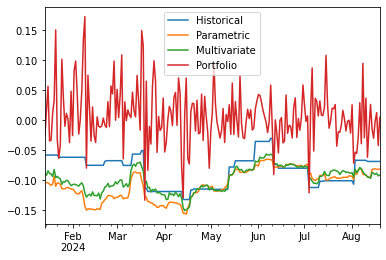

In [67]:
var_data.plot()

<AxesSubplot:>

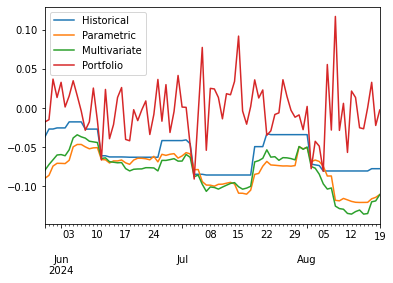

In [68]:
current_var_data.plot()

In [69]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022831,0.013699,0.013699
Kupiec Stat,4.229549,8.431625,8.431625
P-value,0.039726,0.003688,0.003688


In [70]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.083333,0.047619,0.035714
Kupiec Stat,1.650974,0.01018,0.399122
P-value,0.198826,0.919635,0.527543


## Principal Component Analysis

In [71]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77438697, 0.06870612, 0.0565263 , 0.0529467 , 0.04743392])

In [72]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.6558518 , 0.14863089, 0.08801509, 0.0746632 , 0.03283902])

In [73]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

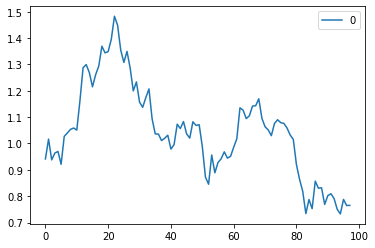

In [74]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

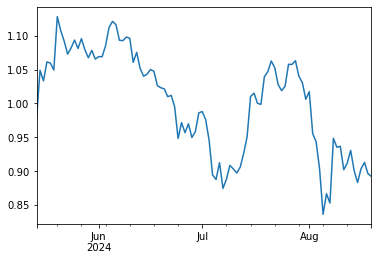

In [75]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()